In [ ]:
# Original code & pre-print can be found at https://github.com/zgr6010/HSI_SSFTT

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import torch
import torch.nn as nn
import torch.optim as optim
from operator import truediv
from scr.get_cls_map import get_cls_map
import time
from scr.SSFTTnet import SSFTTnet
from scr.utils import loadData, applyPCA, createImageCubes, TestDS, acc_reports 

In [2]:
def create_data_loader(config: dict):
    
    X, y = loadData(config['hsi_path'], config['hsi_key'], config['gt_path'], config['gt_key'])
    
    print("HSI shape", X.shape, 'Gt shape', y.shape)
    
    print('\n... ... PCA tranformation ... ...')
    X = applyPCA(X, numComponents=config['pca_components'])
    print('Data shape after PCA: ', X.shape)
    
    print('\n... ... create data cube ... ...')
    X, y = createImageCubes(X, y, windowSize=config['patch_size'])
    print('Data cube X shape: ', X.shape, 'Data cube y shape: ', y.shape)
    
    # Changing the shape of the Xtrain, Ytrain to match the requirements of keras
    X = X.reshape(-1, config['patch_size'], config['patch_size'], config['pca_components'], 1)
    print('before transpose: X shape: ', X.shape)

    # In order to fit the pytorch structure, the data has to be transposed
    X = X.transpose(0, 4, 3, 1, 2)
    print('after transpose: X shape: ', X.shape)
    
    X = TestDS(X, y)
    
    data_loader = torch.utils.data.DataLoader(dataset=X,
                                              batch_size=config['batch_size'],
                                              shuffle=False,
                                              num_workers=4,
                                              )
    
    return data_loader, y

In [3]:
def test(device, net, test_loader):
    
    count = 0
    
    net.eval()
    y_pred_test = 0
    y_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred_test = outputs
            y_test = labels
            count = 1
        else:
            y_pred_test = np.concatenate((y_pred_test, outputs))
            y_test = np.concatenate((y_test, labels))

    return y_pred_test, y_test

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = {"hsi_path": './data/tablet.mat',
          "hsi_key": 'image',
          "gt_path": './data/tablet_gt.mat',
          "gt_key": 'img',
          "test_ratio": 0.9,
          "patch_size": 13,
          "pca_components": 30,
          "batch_size": 64
         }

cuda


In [5]:
data_loader, y = create_data_loader(config)

HSI shape (600, 650, 250) Gt shape (600, 650)

... ... PCA tranformation ... ...
Data shape after PCA:  (600, 650, 30)

... ... create data cube ... ...
Data cube X shape:  (389999, 13, 13, 30) Data cube y shape:  (389999,)
before transpose: X shape:  (389999, 13, 13, 30, 1)
after transpose: X shape:  (389999, 1, 30, 13, 13)


In [6]:
model = SSFTTnet().to(device)
model.load_state_dict(torch.load("./checkpoints/SSFTTnet_tablet.pth"))

<All keys matched successfully>

In [9]:
y_pred_test, y_test = test(device, model, data_loader)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
------Get classification maps successful-------


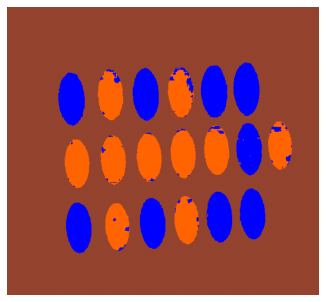

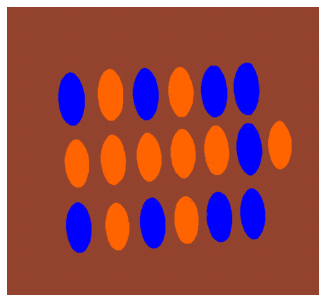

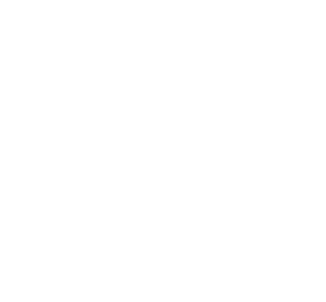

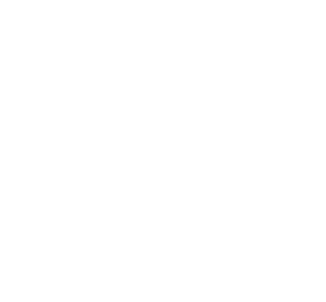

In [18]:
# Evaluation indicators

gt = sio.loadmat(config["gt_path"])[config["gt_key"]]

classification, oa, confusion, each_acc, aa, kappa = acc_reports(y_test, y_pred_test)
classification = str(classification)
file_name = "./classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('{} Each accuracy (%)'.format(each_acc))
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

get_cls_map(model, device, data_loader, gt, './')

(389999,)